In [18]:
import pandas as pd
from preprocess_methods import *
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from matplotlib import pyplot as plt

## Visualize results

In [21]:
file_path = "preprocessed_data/db.fasta"
df = parse_fasta_to_dataframe(file_path)
df = df.replace('/', '_', regex=True)
df

,ID,Protein,Species,Sequence
0,NP_002290.2,lactase_phlorizin hydrolase preproprotein,Homo sapiens,MELSWHVVFIALLSFSCWGSDWESDRNFISTAGPLTNDLLHNLSGL...
1,XP_005573098.3,lactase_phlorizin hydrolase,Macaca fascicularis,MELSWHVAFIALLSVSCWGSDWESERNFISTAGPLTNDLLHNLSGP...
2,XP_003909221.3,lactase-phlorizin hydrolase,Papio anubis,MELTWHVAFIALLSVSCWGSDWESERNFISTAGPLTNDLLHNLSGP...
3,XP_010365578.1,lactase-phlorizin hydrolase,Rhinopithecus roxellana,MELSWHAVFIALLSVSSWGSDWESERNFISTAGPLTNDLLHNLSGP...
4,XP_033087543.1,lactase-phlorizin hydrolase,Trachypithecus francoisi,MELSWHAVFIALLSVSSWGSDWESERNFISTAGPLTNDLLHNLSGP...
5,XP_002749525.2,lactase_phlorizin hydrolase,Callithrix jacchus,MELLWHVVFIVLLSFSCWGSDWESDRNFISAAGPLTSDLLNNLSGP...
6,XP_064238875.1,lactase_phlorizin hydrolase,Aotus nancymaae,MELLWHVVFIVLLSFSCCGLDWDSDRNFISAAGPLTNDFLNNPSGL...
7,NP_000760.1,cytochrome P450 2C19,Homo sapiens,MDPFVVLVLCLSCLLLLSIWRQSSGRGKLPPGPTPLPVIGNILQID...
8,XP_030796822.1,cytochrome P450 2C9 isoform X1,Rhinopithecus roxellana,MDSLVVLVLCLSCLLLLSLWRQRSGRGKLPPGPTPLPVIGNILQIN...
9,XP_045217159.2,cytochrome P450 2C9,Macaca fascicularis,MDSLVVLVLCLSCLLLLSLWRQRSGRGKFPPGPTPLPVIGNILQID...


#### Save to more readible fasta format (`protein_specie` instead of `id`)

In [22]:
fasta_file = "preprocessed_data/sequences_readable.fasta"
save_to_fasta(df, fasta_file)

## Run BLAST

`makeblastdb -in sequences_readable.fasta -dbtype prot -out blast/sequences_db `

`blastp -query sequences_readable.fasta -db blast/sequences_db -out blast_results.txt -outfmt 6`

## Clustering methods

#### a) dendrogram

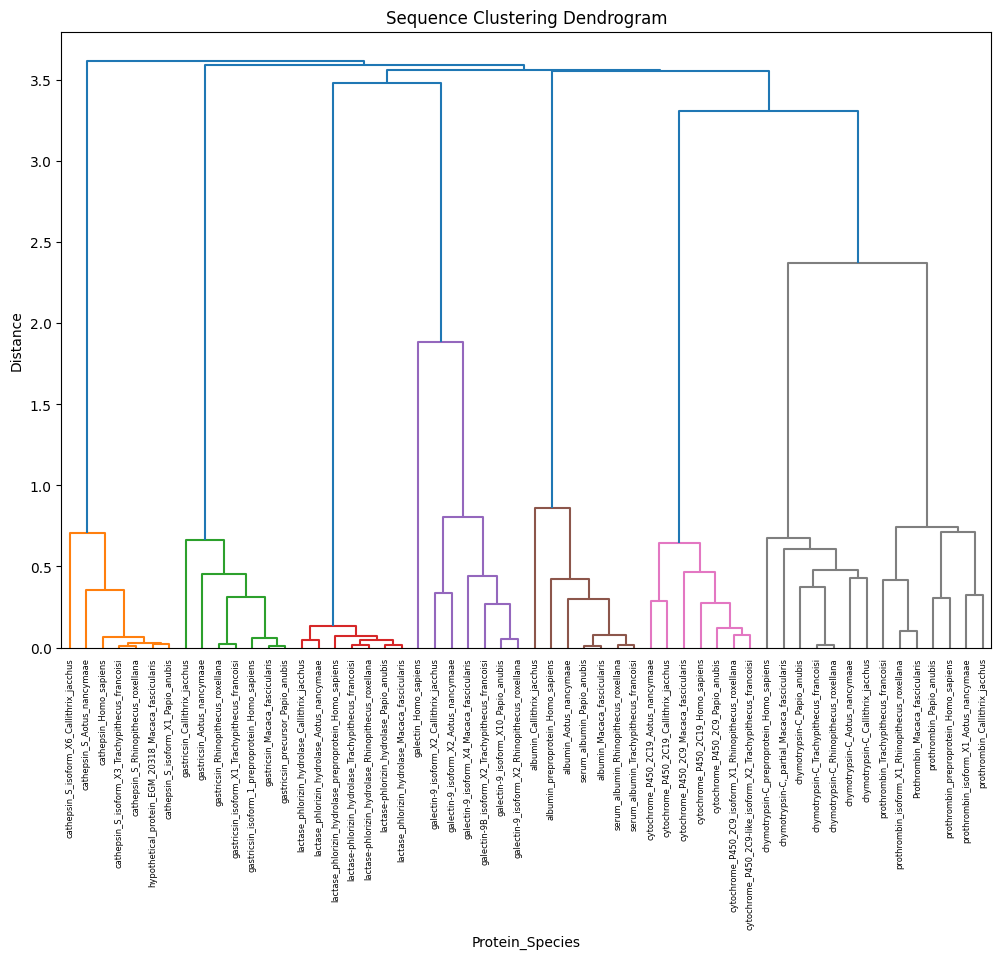

In [23]:
blast_results_file = "preprocessed_data/blast_results.txt"
similarity_matrix = parse_blast_results_to_matrix(blast_results_file)
similarity_matrix.to_csv("results/similarity_matrix.csv")

distance_matrix = 1 - similarity_matrix / 100

linkage_matrix = linkage(distance_matrix, method='average')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=similarity_matrix.index, leaf_rotation=90)
plt.title("Sequence Clustering Dendrogram")
plt.xlabel("Protein_Species")
plt.ylabel("Distance")
plt.savefig("results/dendrogram.png", dpi='figure')
plt.show()

#### b) K-means

In [24]:
distance_array = distance_matrix.values
kmeans = KMeans(n_clusters=8, random_state=42)
labels = kmeans.fit_predict(distance_array)

In [25]:
sequence_ids = similarity_matrix.index
clustered_sequences = pd.DataFrame({
    'Sequence': sequence_ids,
    'Cluster': labels
})

# Print the sequences belonging to each cluster
for cluster_num in range(kmeans.n_clusters):
    print(f"\nCluster {cluster_num + 1}:")
    cluster_members = clustered_sequences[clustered_sequences['Cluster'] == cluster_num]
    print(cluster_members['Sequence'].to_list())


Cluster 1:
['cathepsin_S_Aotus_nancymaae', 'cathepsin_S_isoform_X3_Trachypithecus_francoisi', 'cathepsin_Homo_sapiens', 'hypothetical_protein_EGM_20318_Macaca_fascicularis', 'cathepsin_S_Rhinopithecus_roxellana', 'cathepsin_S_isoform_X6_Callithrix_jacchus', 'cathepsin_S_isoform_X1_Papio_anubis']

Cluster 2:
['prothrombin_isoform_X1_Rhinopithecus_roxellana', 'Prothrombin_Macaca_fascicularis', 'prothrombin_isoform_X1_Aotus_nancymaae', 'prothrombin_Callithrix_jacchus', 'prothrombin_Trachypithecus_francoisi', 'prothrombin_Papio_anubis', 'prothrombin_preproprotein_Homo_sapiens']

Cluster 3:
['gastricsin_Macaca_fascicularis', 'gastricsin_Rhinopithecus_roxellana', 'gastricsin_Callithrix_jacchus', 'gastricsin_isoform_X1_Trachypithecus_francoisi', 'gastricsin_isoform_1_preproprotein_Homo_sapiens', 'gastricsin_precursor_Papio_anubis', 'gastricsin_Aotus_nancymaae']

Cluster 4:
['lactase-phlorizin_hydrolase_Papio_anubis', 'lactase_phlorizin_hydrolase_Callithrix_jacchus', 'lactase_phlorizin_hydrol

Silhouette Score: 0.8377307051128129


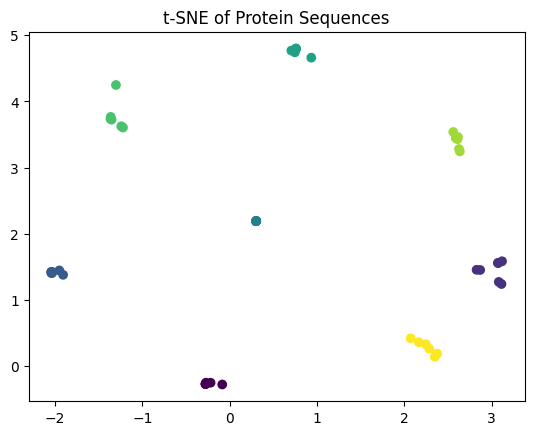

In [26]:
sil_score = silhouette_score(distance_array, labels)
print(f"Silhouette Score: {sil_score}")

tsne = TSNE(n_components=2, random_state=42)
reduced_features = tsne.fit_transform(distance_array)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels)
plt.title("t-SNE of Protein Sequences")
plt.show()